## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import random
import zipfile
import pathlib
import os 


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense,Flatten,Conv2D,MaxPool2D,Activation
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras import regularizers

# Stepps in multiclass image classification

1. Become one with the data
2. Preprocess the data
3. Create a baseline model
4. Fit the model
5. Evaluate the model
6. Adjust different hyperparameters and try to beat the baseline
7. Repeat until satisfied

In [2]:
# Download zip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

# Unzip our data
zip_ref = zipfile.ZipFile("10_food_classes_all_data.zip","r")
zip_ref.extractall()
zip_ref.close()

--2021-11-05 14:08:22--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.133.128, 74.125.140.128, 108.177.15.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.133.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  89.0MB/s    in 5.8s    

2021-11-05 14:08:28 (85.1 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



# 1. Become one with the data

In [3]:
# Lets traverse through 10 food_clases directory and list number of files
for dirpath,dirnames,filenames in os.walk("10_food_classes_all_data"):
  #print(f" There are {len(dirnames)} Directories and {len(filenames)} images in {dirpath}.")
  if len(dirnames) < 1:
    print(f"There are {len(filenames)} images in {dirpath}.")
  elif  len(filenames) <= 1:
    print(f"There are {len(dirnames)} Directories in {dirpath}.")

There are 2 Directories in 10_food_classes_all_data.
There are 10 Directories in 10_food_classes_all_data/test.
There are 250 images in 10_food_classes_all_data/test/steak.
There are 250 images in 10_food_classes_all_data/test/grilled_salmon.
There are 250 images in 10_food_classes_all_data/test/ice_cream.
There are 250 images in 10_food_classes_all_data/test/hamburger.
There are 250 images in 10_food_classes_all_data/test/chicken_curry.
There are 250 images in 10_food_classes_all_data/test/sushi.
There are 250 images in 10_food_classes_all_data/test/ramen.
There are 250 images in 10_food_classes_all_data/test/pizza.
There are 250 images in 10_food_classes_all_data/test/fried_rice.
There are 250 images in 10_food_classes_all_data/test/chicken_wings.
There are 10 Directories in 10_food_classes_all_data/train.
There are 750 images in 10_food_classes_all_data/train/steak.
There are 750 images in 10_food_classes_all_data/train/grilled_salmon.
There are 750 images in 10_food_classes_all_dat

In [4]:
# Lets setup train and test directories
train_dir = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"

In [5]:
# Get the subdirectories (class_names)
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted(item.name for item in data_dir.glob("*")))
print(class_names)

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


In [6]:
def view_random_image(target_dir,target_class):
  """
  INFO: Plots out a random image from a target directory
  """
  target_folder = target_dir + "/" + target_class
  random_image = random.sample(os.listdir(target_folder),1)
  # Plot out the image
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")
  print(f" Image shape: {img.shape}") # Shows the shape of the image

  return img

In [7]:
# Plot a random image for each class
def view_images(target_dir):
  """
  Plots a random image from each class
  """
  plt.figure(figsize=(10,10))
  for i in range(10):
    plt.subplot(5,5,i+1)

    target_folder = target_dir + "/" + class_names[i]
    random_image = random.sample(os.listdir(target_folder),1)
    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.axis("off")
    plt.title(class_names[i])

In [8]:
# Lets try to plot the validation and training curves separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation methods
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # Plot loss
  plt.plot(epochs,loss,label = "training loss")
  plt.plot(epochs,val_loss,label = "validation loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()
  # Plot accuracy
  plt.figure()
  plt.plot(epochs,accuracy,label = "training accuracy")
  plt.plot(epochs,val_accuracy,label = "validation accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()

 Image shape: (512, 512, 3)


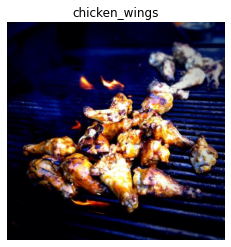

In [9]:
# View a random image from a random target class
img = view_random_image(target_dir=train_dir,target_class=random.choice(class_names));

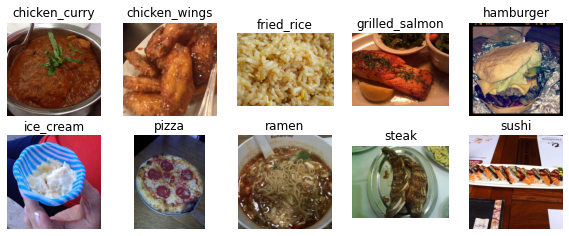

In [10]:
view_images(target_dir = train_dir)

# 2. Preprocess the data

In [11]:
# Simple rescale datagen
train_datagen = ImageDataGenerator(rescale = 1/255.)
test_datagen = ImageDataGenerator(rescale = 1/255.)

# Augmented datagen
train_datagen_augmented = ImageDataGenerator(rescale = 1/255.,
                                             rotation_range = 0.3,
                                             zoom_range = 0.3,
                                             width_shift_range = 0.2,
                                             height_shift_range = 0.2,
                                             horizontal_flip = True)

In [12]:
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size = (224,224),
                                               batch_size = 32,
                                               class_mode = "categorical")

train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                                   target_size = (224,224),
                                                                   batch_size = 32,
                                                                   class_mode = "categorical")

test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size = (224,224),
                                             batch_size = 32,
                                             class_mode = "categorical")

Found 7500 images belonging to 10 classes.
Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


# 3. Create a baseline model

In [13]:
# Create model
model_1 = Sequential([
    Conv2D(10,3,activation="relu",input_shape = (224,224,3)),
    Conv2D(10,3,activation="relu"),
    MaxPool2D(),
    Conv2D(10,3,activation="relu"),
    Conv2D(10,3,activation="relu"),
    MaxPool2D(),
    Flatten(),
    Dense(10,activation="softmax")
])

# Compile the model
model_1.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

# 4. Fit the model

In [14]:
# Fit the model
history_1 = model_1.fit(train_data,
                        epochs = 5,
                        steps_per_epoch = len(train_data),
                        validation_data = test_data,
                        validation_steps = len(test_data))

Epoch 1/5
235/235 [==============================] - 86s 233ms/step - loss: 2.1518 - accuracy: 0.2139 - val_loss: 2.0230 - val_accuracy: 0.2812
Epoch 2/5
235/235 [==============================] - 54s 231ms/step - loss: 1.8674 - accuracy: 0.3532 - val_loss: 1.9191 - val_accuracy: 0.3372
Epoch 3/5
235/235 [==============================] - 55s 235ms/step - loss: 1.5690 - accuracy: 0.4649 - val_loss: 1.9836 - val_accuracy: 0.3280
Epoch 4/5
235/235 [==============================] - 55s 236ms/step - loss: 1.0790 - accuracy: 0.6440 - val_loss: 2.2369 - val_accuracy: 0.3048
Epoch 5/5
235/235 [==============================] - 55s 236ms/step - loss: 0.5016 - accuracy: 0.8423 - val_loss: 3.2015 - val_accuracy: 0.2860


# 5. Evaluate the model

In [15]:
model_1.evaluate(test_data)

79/79 [==============================] - 13s 160ms/step - loss: 3.2015 - accuracy: 0.2860


[3.2014899253845215, 0.28600001335144043]

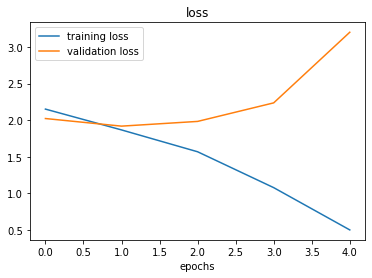

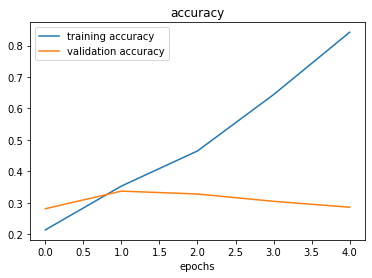

In [16]:
plot_loss_curves(history_1)

our model seems to be **overfitting** on the training data.

# 6. Adjust the model hyperparameters
Lets try to beat the baseline model and reduce overfitting


---
Ways to reduce overfitting
* Get more data - pretty exlanatory
* Simplify the model - we could simplify a model by reducing the layers it has or reduce the number of hidden units in a layer
* We could use data augmentation
* We could use some kernel regularization
* Use transfer learning



In [17]:
# Lets use the augmented data and also simplify the model
model_2 = Sequential([
    Conv2D(10,3,activation="relu",input_shape = (224,224,3)),
    MaxPool2D(),
    Conv2D(10,3,activation="relu"),
    MaxPool2D(),
    Conv2D(10,3,activation="relu"),
    Flatten(),
    Dense(10,activation="softmax")
])

# Compile the model
model_2.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

# Fit the model using augmented training data
history_2 = model_2.fit(train_data_augmented,
                        epochs = 5,
                        steps_per_epoch = len(train_data_augmented),
                        validation_data = test_data,
                        validation_steps = len(test_data))

Epoch 1/5
235/235 [==============================] - 125s 530ms/step - loss: 2.1924 - accuracy: 0.1984 - val_loss: 2.0156 - val_accuracy: 0.2684
Epoch 2/5
235/235 [==============================] - 124s 528ms/step - loss: 2.0797 - accuracy: 0.2537 - val_loss: 1.9577 - val_accuracy: 0.3200
Epoch 3/5
235/235 [==============================] - 125s 533ms/step - loss: 2.0310 - accuracy: 0.2839 - val_loss: 1.9086 - val_accuracy: 0.3292
Epoch 4/5
235/235 [==============================] - 125s 532ms/step - loss: 1.9658 - accuracy: 0.3157 - val_loss: 1.8180 - val_accuracy: 0.3692
Epoch 5/5
235/235 [==============================] - 126s 534ms/step - loss: 1.9510 - accuracy: 0.3144 - val_loss: 1.7923 - val_accuracy: 0.3740


In [18]:
model_2.evaluate(test_data) 

79/79 [==============================] - 12s 154ms/step - loss: 1.7923 - accuracy: 0.3740


[1.7922687530517578, 0.37400001287460327]

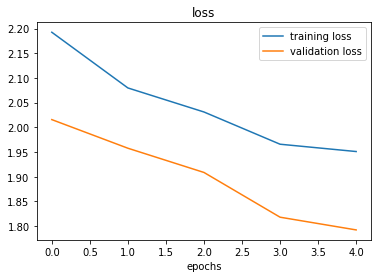

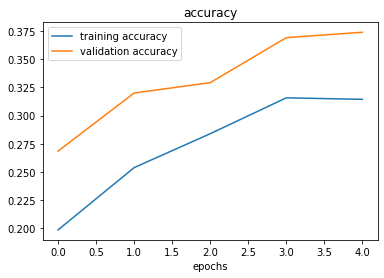

In [19]:
plot_loss_curves(history_2)

Lets try to improve further by setting up a callback and letting the model train for longer epochs. Additionaly add kernel regularization

In [24]:
# Create the model

model_3 = Sequential([
    Conv2D(64,3,activation="relu",kernel_regularizer=tf.keras.regularizers.l2(1e-4),input_shape =(224,224,3)),
    Conv2D(32,3,activation="relu"),
    MaxPool2D(),
    Conv2D(16,3,activation="relu"),
    Conv2D(10,3,activation="relu"),
    Flatten(),
    Dense(10,activation="softmax")
])

# Compile the model
model_3.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

# Set up callbacks
callback = tf.keras.callbacks.EarlyStopping(monitor="accuracy",patience = 2)

# Finally fit the model using the augmented training data
history_3 = model_3.fit(train_data_augmented,
                        epochs = 50,
                        steps_per_epoch = len(train_data_augmented),
                        validation_data = test_data,
                        validation_steps = len(test_data),
                        callbacks = [callback])

Epoch 1/50
235/235 [==============================] - 144s 599ms/step - loss: 2.3157 - accuracy: 0.1176 - val_loss: 2.2535 - val_accuracy: 0.1556
Epoch 2/50
235/235 [==============================] - 139s 591ms/step - loss: 2.2578 - accuracy: 0.1623 - val_loss: 2.2026 - val_accuracy: 0.1912
Epoch 3/50
235/235 [==============================] - 138s 588ms/step - loss: 2.2346 - accuracy: 0.1652 - val_loss: 2.1887 - val_accuracy: 0.1832
Epoch 4/50
235/235 [==============================] - 138s 588ms/step - loss: 2.2178 - accuracy: 0.1829 - val_loss: 2.1640 - val_accuracy: 0.2144
Epoch 5/50
235/235 [==============================] - 138s 587ms/step - loss: 2.1785 - accuracy: 0.2124 - val_loss: 2.0917 - val_accuracy: 0.2692
Epoch 6/50
235/235 [==============================] - 139s 590ms/step - loss: 2.1353 - accuracy: 0.2405 - val_loss: 2.0276 - val_accuracy: 0.2860
Epoch 7/50
235/235 [==============================] - 139s 592ms/step - loss: 2.1022 - accuracy: 0.2611 - val_loss: 2.0042 -

In [25]:
model_3.evaluate(test_data)

79/79 [==============================] - 14s 178ms/step - loss: 1.6799 - accuracy: 0.4636


[1.6798557043075562, 0.4636000096797943]

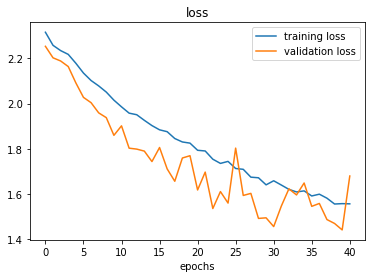

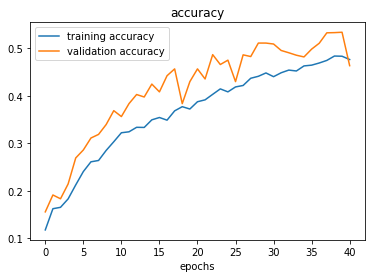

In [26]:
plot_loss_curves(history_3)

## Make a function that predicts and plots custom images

In [33]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224):
  """
  Reads an image from filename, turns it into a tensor
  and reshapes it to (img_shape, img_shape, colour_channel).
  """
  # Read in target file (an image)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 colour channels 
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
  img = tf.image.decode_image(img, channels=3)

  # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img, size = [img_shape, img_shape])

  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img

In [34]:
def pred_and_plot(model,filename,class_names=class_names):
  """
  Imports an image located at filename make a prediction with the given model
  and plos the image with the predicted class as the title
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

In [35]:
# Download a few images

!wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg
!wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg
!wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-hamburger.jpeg
!wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-sushi.jpeg

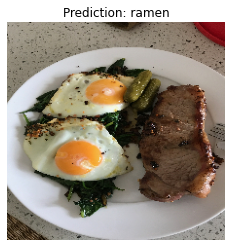

In [36]:
# Finnaly make predictions on said images
pred_and_plot(model_3,filename="03-steak.jpeg")

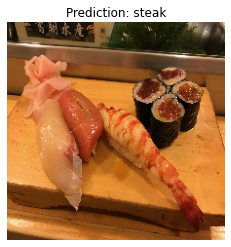

In [37]:
pred_and_plot(model_3, "03-sushi.jpeg", class_names)

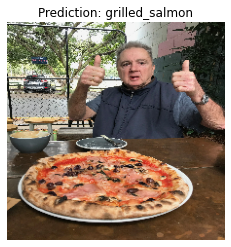

In [38]:
pred_and_plot(model_3, "03-pizza-dad.jpeg", class_names)

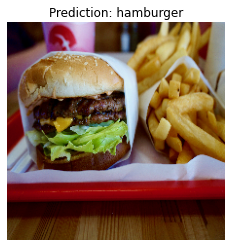

In [39]:
pred_and_plot(model_3, "03-hamburger.jpeg")